In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [2]:
stack_idx = '17'
models = '1-31'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [9]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
31
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [10]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [11]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_29,log_parea_pred_29,pred_30,log_pred_30,log_parea_pred_30,pred_31,log_pred_31,log_parea_pred_31,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.349368,12.120265,6.687262e+05,13.413132,12.184028,6.789011e+05,13.428232,12.199129,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.961478,13.564910,3.180461e+06,14.972537,13.575969,2.996046e+06,14.912804,13.516237,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.094058,14.374103,9.739343e+06,16.091684,14.371729,9.840726e+06,16.102040,14.382085,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.351248,13.743901,1.242492e+07,16.335215,13.727868,1.246321e+07,16.338292,13.730945,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.936413,12.391388,1.227169e+06,14.020221,12.475195,1.159105e+06,13.963160,12.418134,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29,pred_30,log_pred_30,log_parea_pred_30,pred_31,log_pred_31,log_parea_pred_31
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.284537,1.458851e+07,16.495745,15.266638,1.341823e+07,16.412125,15.183018,1.235658e+07,16.329699,15.100592
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.138282,3.930381e+06,15.184247,13.139628,3.931973e+06,15.184652,13.140033,3.933268e+06,15.184982,13.140363
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.683307,1.053625e+07,16.170332,13.671312,1.221239e+07,16.317962,13.818941,1.039900e+07,16.157220,13.658199
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.799625,5.922934e+06,15.594343,14.782410,5.957837e+06,15.600218,14.788286,5.944207e+06,15.597928,14.785996
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.131217,1.092658e+06,13.904125,12.143863,1.110080e+06,13.919943,12.159682,1.140621e+06,13.947084,12.186822


### Check models scores

In [12]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194
27 model-28 5901.874202
28 model-29 5884.873848
29 model-30 5864.872101
30 model-31 5783.868923


### Output stack result

In [13]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

In [14]:
best_coeffs = np.array([-0.04022074,  0.01043184, -0.01826028,  0.0545511 ,  0.14830453,
         0.03260304,  0.01783987,  0.11785695,  0.03561798, -0.06369236,
        -0.1098837 ,  0.0366819 ,  0.05728057, -0.10344856, -0.03374385,
         0.03829215,  0.04380739,  0.11497733, -0.00494467, -0.06550493,
        -0.03554945, -0.00478544,  0.00489739,  0.17789231, -0.00297433,
         0.1460801 ,  0.36373621, -0.06810277, -0.09173799,  0.18100983,
         0.06701488, -0.08536315])

In [15]:
def predict(df, x):
    y_pred_final = df.loc[:, cols_opt].dot(x)
    y_pred_final = np.expm1(y_pred_final)
    if is_per_area:
        y_pred_final = y_pred_final * df['building_area']
    return y_pred_final

In [16]:
cv['total_price_pred'] = predict(cv, best_coeffs)

In [17]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,pred_30,log_pred_30,log_parea_pred_30,pred_31,log_pred_31,log_parea_pred_31,log_total_price,log_parea_total_price,constant_1,total_price_pred
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,6.687262e+05,13.413132,12.184028,6.789011e+05,13.428232,12.199129,13.381036,12.151933,1,6.289706e+05
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,3.180461e+06,14.972537,13.575969,2.996046e+06,14.912804,13.516237,15.015913,13.619345,1,3.056549e+06
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,9.739343e+06,16.091684,14.371729,9.840726e+06,16.102040,14.382085,16.074236,14.354282,1,9.781632e+06
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,1.242492e+07,16.335215,13.727868,1.246321e+07,16.338292,13.730945,16.469809,13.862462,1,1.272997e+07
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,1.227169e+06,14.020221,12.475195,1.159105e+06,13.963160,12.418134,13.544637,11.999613,1,1.252177e+06


In [19]:
cv.to_csv('output/stack_spopt-parea_{}_{}_smoothobj-cv-one.csv'.format(stack_idx, models), index=False)

In [20]:
cv['log_total_price_pred'] = np.log1p(cv['total_price_pred'])
cv['log_parea_total_price_pred'] = np.log1p(cv['total_price_pred'] / cv['building_area'])

### Percent Error

In [21]:
cv['pe'] = (cv['total_price_pred'] - cv['total_price']) / cv['total_price']

In [22]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,pred_31,log_pred_31,log_parea_pred_31,log_total_price,log_parea_total_price,constant_1,total_price_pred,log_total_price_pred,log_parea_total_price_pred,pe
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,6.789011e+05,13.428232,12.199129,13.381036,12.151933,1,6.289706e+05,13.351841,12.122738,-0.028772
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,2.996046e+06,14.912804,13.516237,15.015913,13.619345,1,3.056549e+06,14.932797,13.536230,-0.079755
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,9.840726e+06,16.102040,14.382085,16.074236,14.354282,1,9.781632e+06,16.096017,14.376062,0.022020
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,1.246321e+07,16.338292,13.730945,16.469809,13.862462,1,1.272997e+07,16.359470,13.752123,-0.104470
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,1.159105e+06,13.963160,12.418134,13.544637,11.999613,1,1.252177e+06,14.040395,12.495369,0.641743


#### Plots

In [23]:
import matplotlib.pyplot as plt

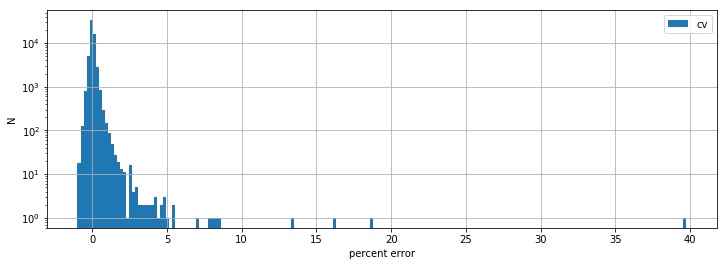

In [24]:
plt.figure(figsize=(12, 4))
plt.hist(cv['pe'], bins=200, label='cv')
plt.xlabel('percent error'); plt.ylabel('N')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

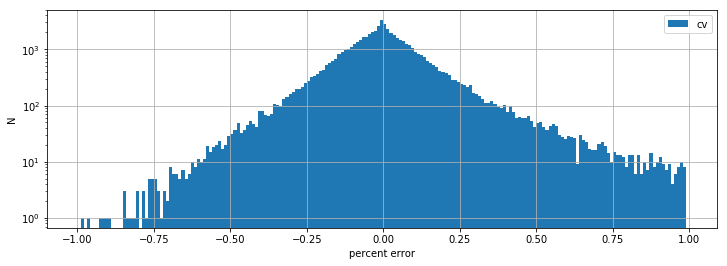

In [25]:
plt.figure(figsize=(12, 4))
plt.hist(cv['pe'], bins=np.arange(-1, 1, 0.01), label='cv')
plt.xlabel('percent error'); plt.ylabel('N')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

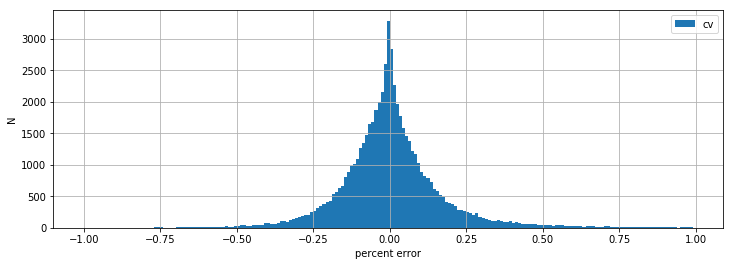

In [26]:
plt.figure(figsize=(12, 4))
plt.hist(cv['pe'], bins=np.arange(-1, 1, 0.01), label='cv')
plt.xlabel('percent error'); plt.ylabel('N')
plt.legend(); plt.grid(); plt.show()

#### Samples with large percent error

In [27]:
cv['small_error'] = np.abs(cv['pe']) < 0.5

In [28]:
cv['small_error'].sum()

58488

In [29]:
(np.abs(cv['pe']) < 1).sum()

59719

In [30]:
(np.abs(cv['pe']) < 0.3).sum()

55191

#### Small vs large error distribution

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


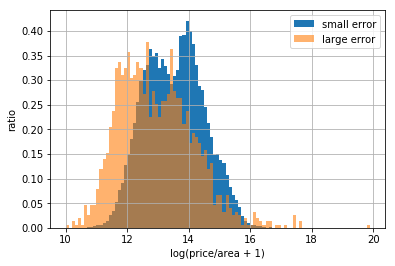

In [31]:
plot_bins = np.arange(10, 20, 0.1)
plt.hist(cv.loc[cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


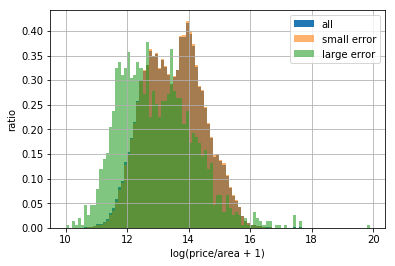

In [32]:
plot_bins = np.arange(10, 20, 0.1)
plt.hist(cv['log_parea_total_price'], bins=plot_bins, 
         label='all', normed=True)
plt.hist(cv.loc[cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='small error', normed=True, alpha=0.6)
plt.hist(cv.loc[~cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


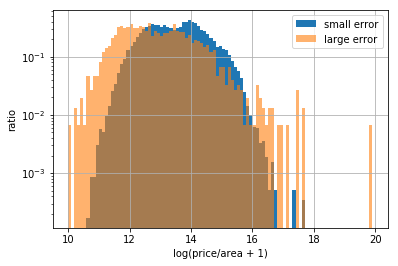

In [33]:
plot_bins = np.arange(10, 20, 0.1)
plt.hist(cv.loc[cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


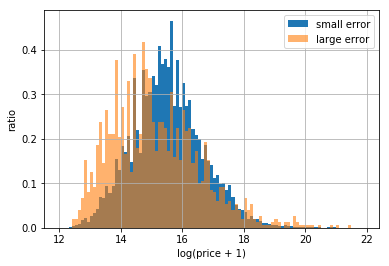

In [34]:
plot_bins = np.arange(12, 22, 0.1)
plt.hist(cv.loc[cv['small_error'], 'log_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_error'], 'log_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


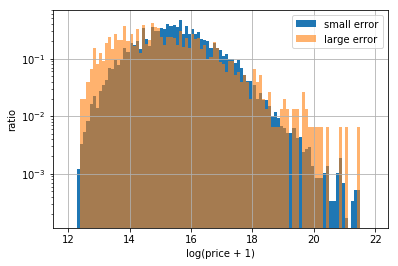

In [35]:
plot_bins = np.arange(12, 22, 0.1)
plt.hist(cv.loc[cv['small_error'], 'log_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_error'], 'log_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

#### Log error

In [36]:
cv['log_error'] = cv['log_total_price_pred'] - cv['log_total_price']

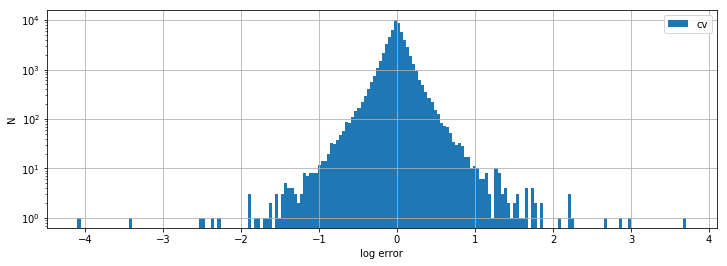

In [37]:
plt.figure(figsize=(12, 4))
plt.hist(cv['log_error'], bins=200, label='cv')
plt.xlabel('log error'); plt.ylabel('N')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

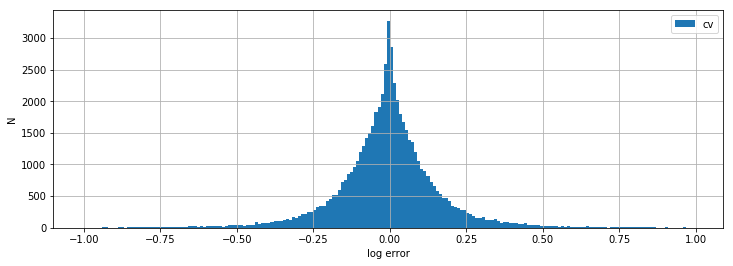

In [38]:
plt.figure(figsize=(12, 4))
plt.hist(cv['log_error'], bins=np.arange(-1, 1, 0.01), label='cv')
plt.xlabel('log error'); plt.ylabel('N')
plt.legend(); plt.grid(); plt.show()

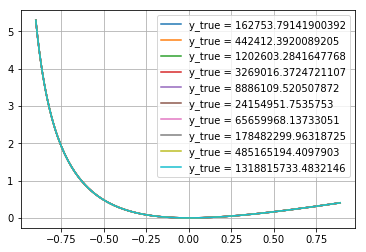

In [39]:
x_pe = np.arange(-0.9, 0.9, 0.01)
for y_base in np.expm1(np.arange(12, 22, 1)):
    y_true = np.ones(len(x_pe))*y_base
    y_pred = x_pe*y_true + y_true
    y_sle = np.square(np.log1p(y_pred) - np.log1p(y_true))
    plt.plot(x_pe, y_sle, label='y_true = '+str(y_base))
plt.legend(); plt.grid()
plt.show()

In [40]:
(np.abs(cv['log_error']) < 0.7).sum(), (np.abs(cv['log_error']) < 0.7).mean()

(59433, 0.99055)

In [41]:
(np.abs(cv['log_error']) < 0.7).sum(), (np.abs(cv['log_error']) < 0.7).mean()

(59433, 0.99055)

In [42]:
cv['small_log_error'] = np.abs(cv['log_error']) < 0.5

#### Small vs large log error distribution

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


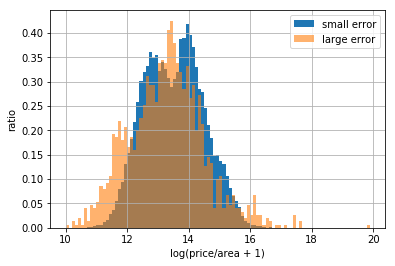

In [43]:
plot_bins = np.arange(10, 20, 0.1)
plt.hist(cv.loc[cv['small_log_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_log_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


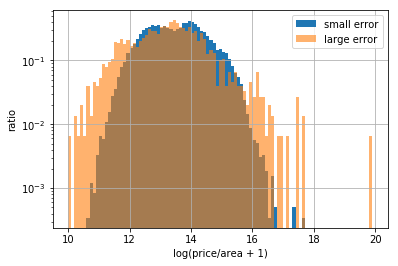

In [44]:
plot_bins = np.arange(10, 20, 0.1)
plt.hist(cv.loc[cv['small_log_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_log_error'], 'log_parea_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


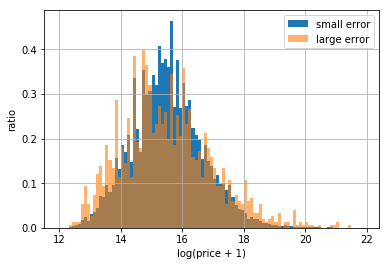

In [45]:
plot_bins = np.arange(12, 22, 0.1)
plt.hist(cv.loc[cv['small_log_error'], 'log_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_log_error'], 'log_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


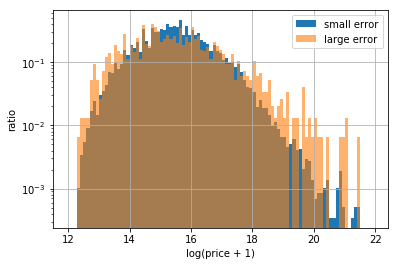

In [46]:
plot_bins = np.arange(12, 22, 0.1)
plt.hist(cv.loc[cv['small_log_error'], 'log_total_price'], bins=plot_bins, 
         label='small error', normed=True)
plt.hist(cv.loc[~cv['small_log_error'], 'log_total_price'], bins=plot_bins, 
         label='large error', normed=True, alpha=0.6)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

#### Output small error sets

In [47]:
cv = cv.sort_values('log_error').reset_index(drop=True)

##### 1%

In [48]:
half_rank_size = int(len(cv)*0.01/2); half_rank_size

300

In [49]:
cv['small_log_error_01'] = False
cv.loc[half_rank_size:len(cv)-half_rank_size-1, 'small_log_error_01'] = True
cv['small_log_error_01'].sum()

59400

##### 3%

In [50]:
half_rank_size = int(len(cv)*0.03/2); half_rank_size

900

In [51]:
cv['small_log_error_03'] = False
cv.loc[half_rank_size:len(cv)-half_rank_size-1, 'small_log_error_03'] = True
cv['small_log_error_03'].sum()

58200

##### 5%

In [52]:
half_rank_size = int(len(cv)*0.05/2); half_rank_size

1500

In [53]:
cv['small_log_error_05'] = False
cv.loc[half_rank_size:len(cv)-half_rank_size-1, 'small_log_error_05'] = True
cv['small_log_error_05'].sum()

57000

#### Positive vs negative

In [54]:
print('percent error')
for error_gp in [1, 3, 5]:
    print(error_gp, 'positive ratio:', (cv.loc[~cv['small_log_error_%02d'%error_gp], 'pe'] > 0).mean())

percent error
1 positive ratio: 0.5
3 positive ratio: 0.5
5 positive ratio: 0.5


In [55]:
print('log error')
for error_gp in [1, 3, 5]:
    print(error_gp, 'positive ratio:', (cv.loc[~cv['small_log_error_%02d'%error_gp], 'log_error'] > 0).mean())

log error
1 positive ratio: 0.5
3 positive ratio: 0.5
5 positive ratio: 0.5


#### Percent Error distribution

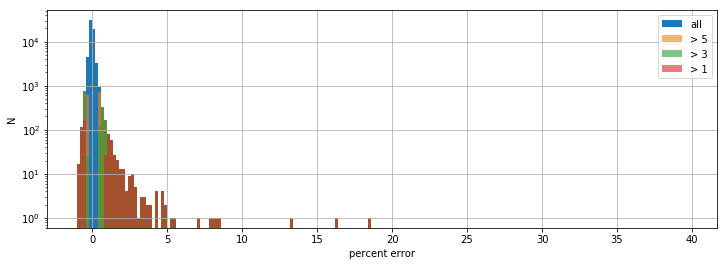

In [56]:
plt.figure(figsize=(12, 4))
x_p_min, x_p_max = cv['pe'].min(), cv['pe'].max()
plot_bins = np.arange(x_p_min, x_p_max, 0.2)
plt.hist(cv['pe'], bins=plot_bins, label='all')
for error_gp in [5, 3, 1]:
    plt.hist(cv.loc[~cv['small_log_error_%02d'%error_gp], 'pe'], 
             bins=plot_bins, label='> '+str(error_gp), alpha=0.6)
plt.xlabel('percent error'); plt.ylabel('N')
plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [57]:
# Output
if False:
    for error_gp in [1, 3, 5]:
        cv.loc[cv['small_log_error_%02d'%error_gp], 
               ['building_id']].to_csv('dataset/building_we_care_%d.csv'%error_gp, index=False)

### All model error distribution

#### train true vs cv pred

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


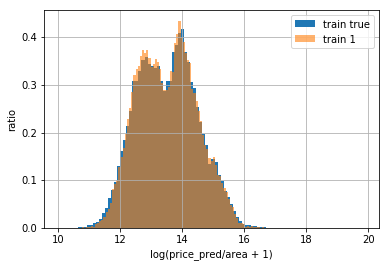

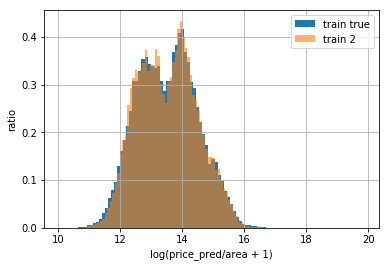

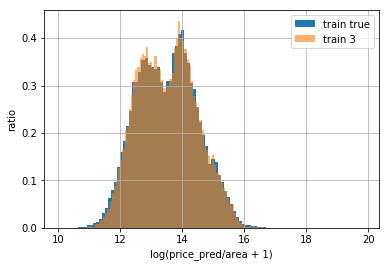

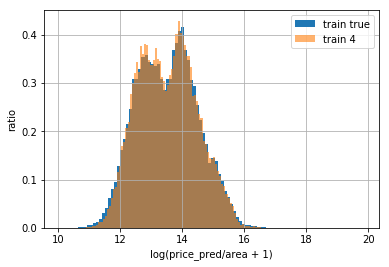

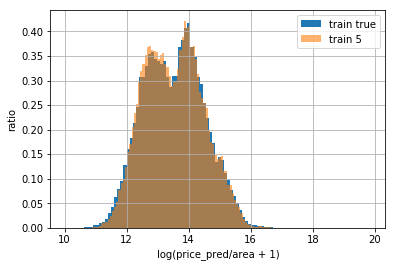

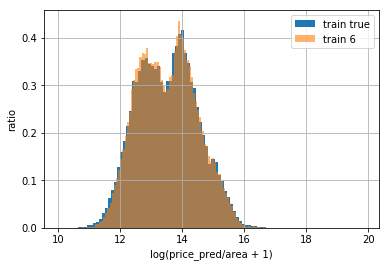

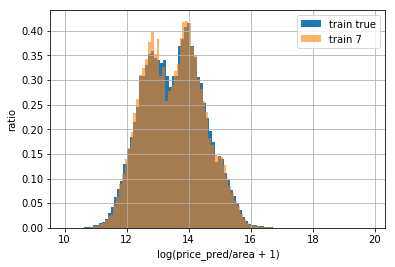

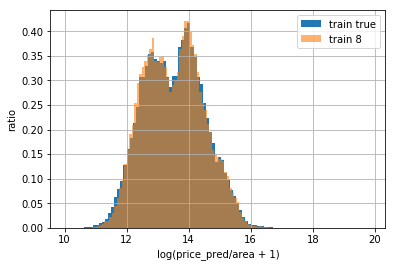

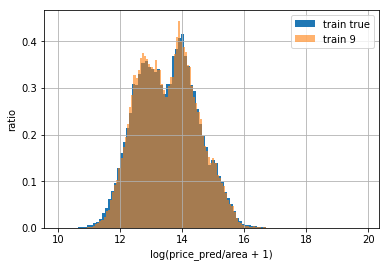

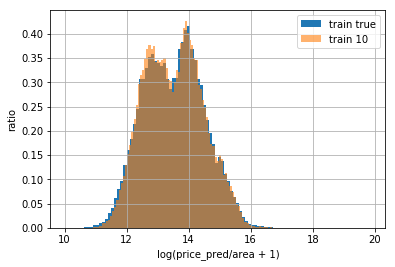

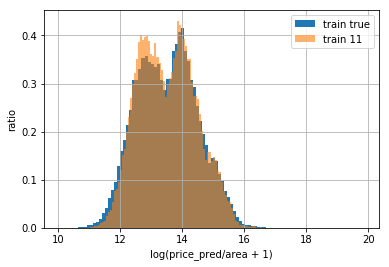

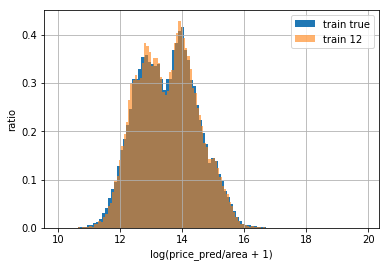

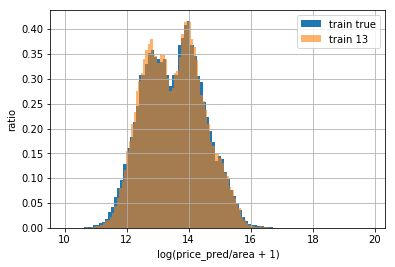

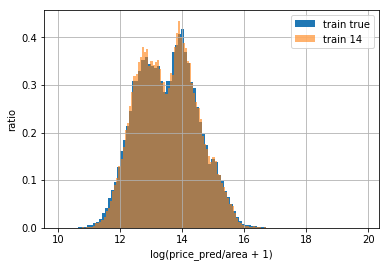

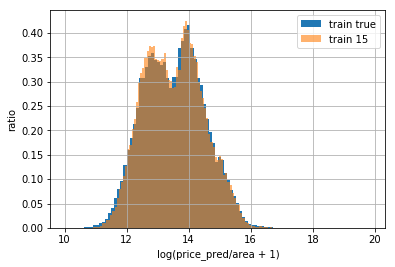

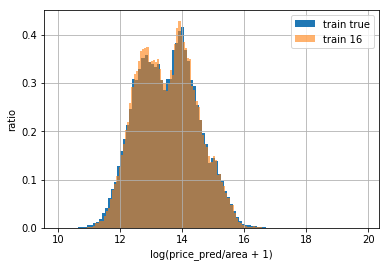

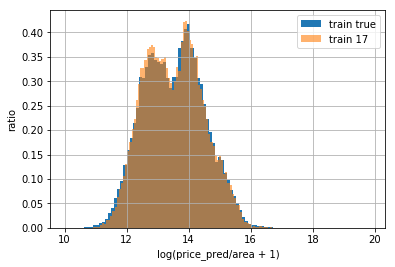

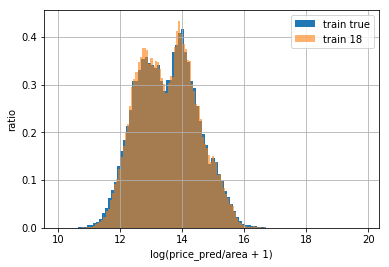

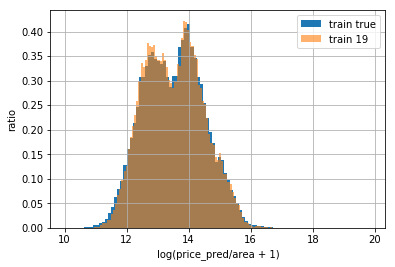

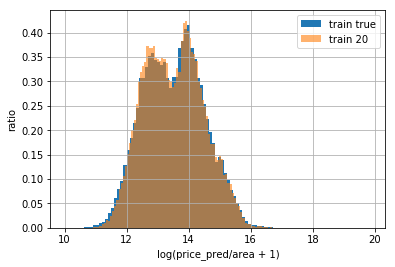

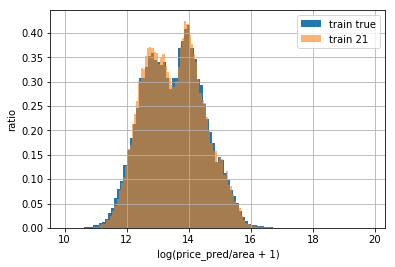

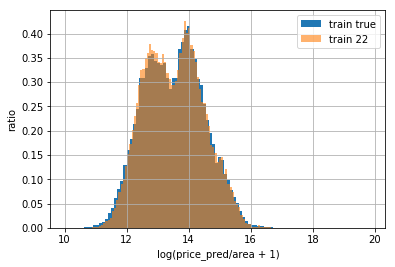

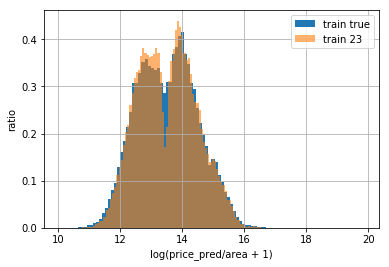

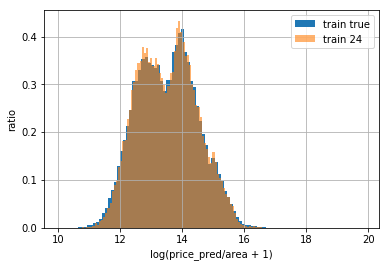

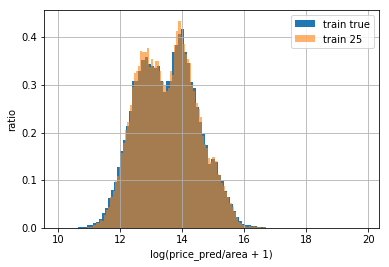

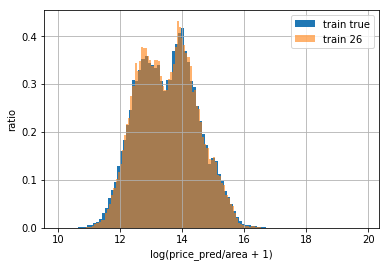

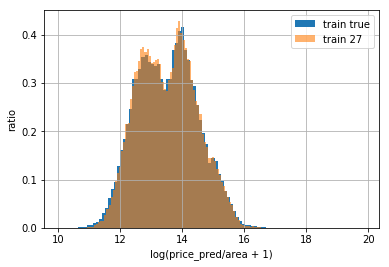

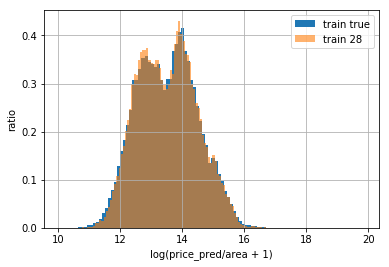

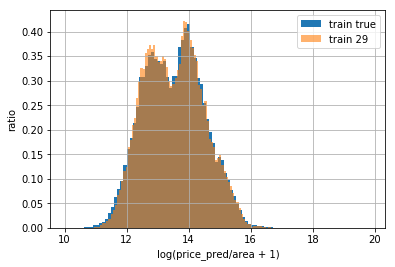

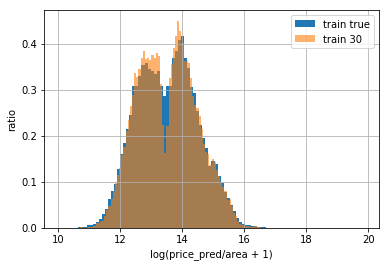

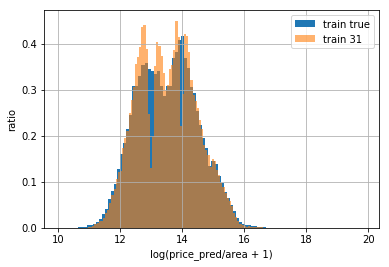

In [58]:
for i in idx_models:
    plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
    plt.hist(cv['log_parea_pred_%d'%i], bins=100, label='cv %d'%i, normed=True, alpha=0.6)
    #plt.hist(test['log_parea_pred_%d'%i], bins=100, label='test %d'%i, normed=True, alpha=0.6)
    plt.xlabel('log(price_pred/area + 1)'); plt.ylabel('ratio')
    plt.legend(); plt.grid(); plt.show()

#### cv vs test

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


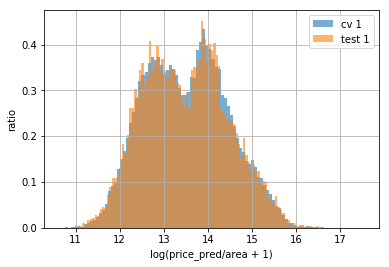

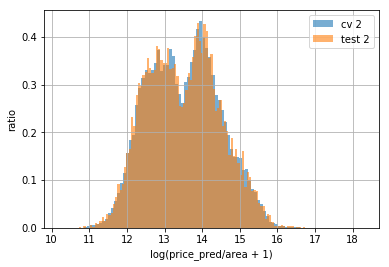

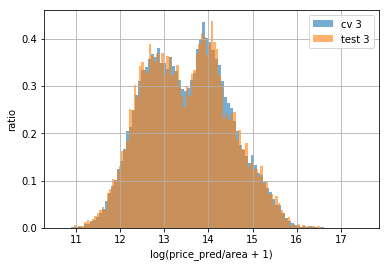

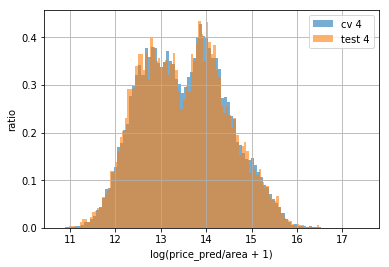

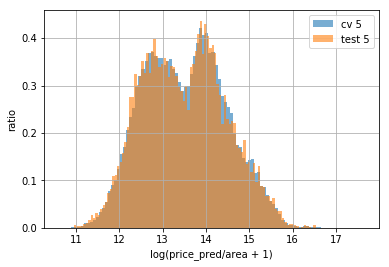

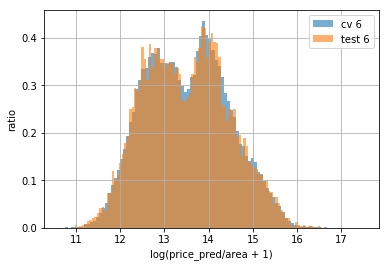

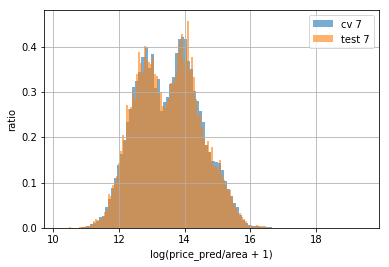

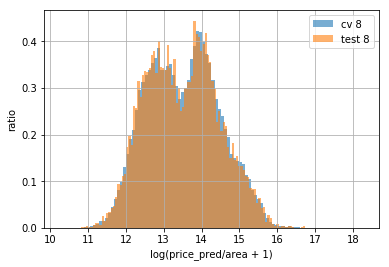

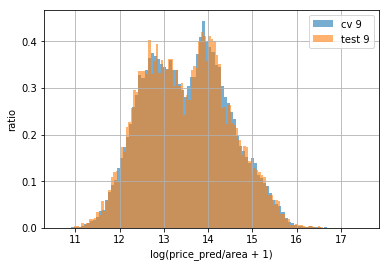

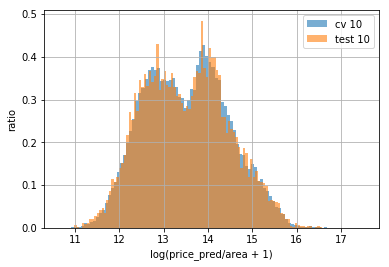

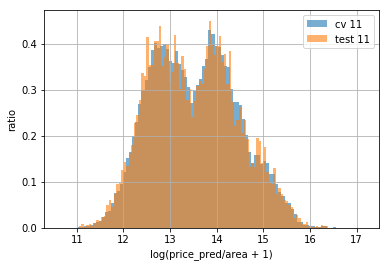

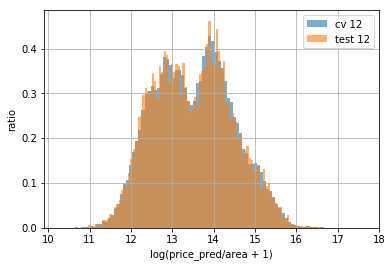

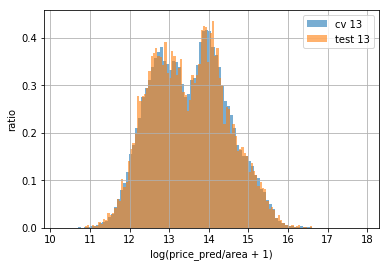

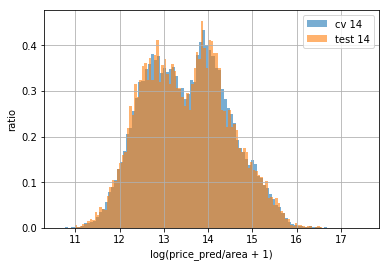

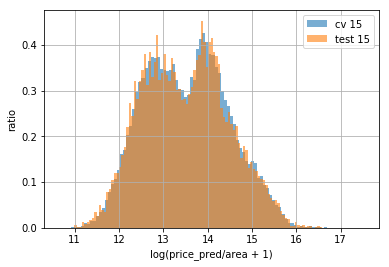

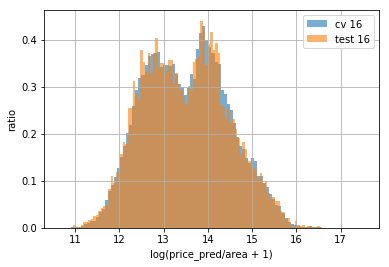

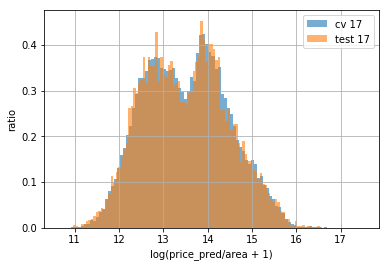

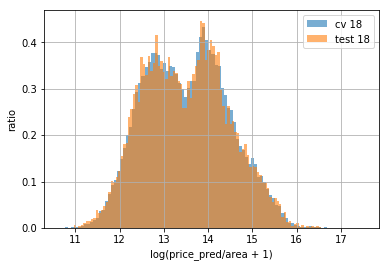

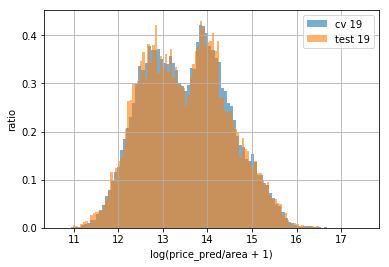

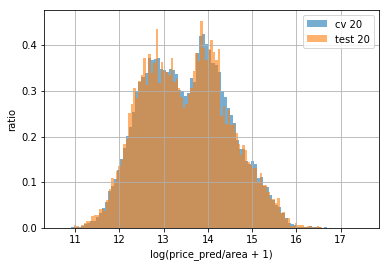

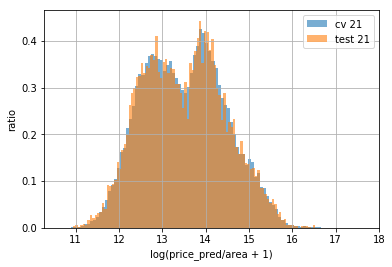

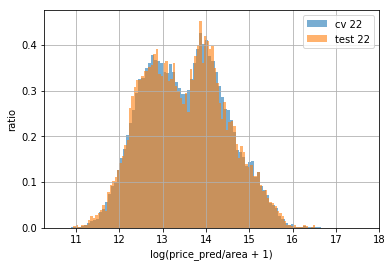

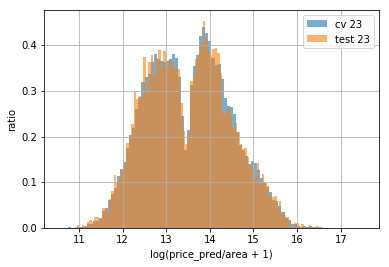

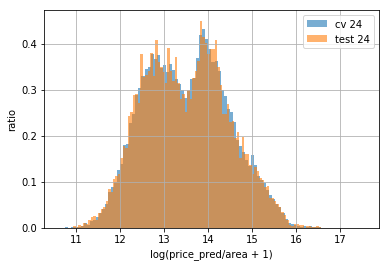

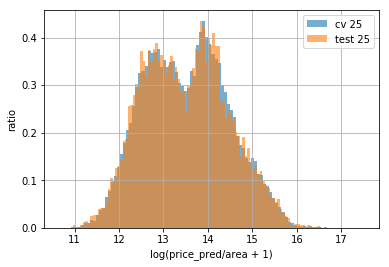

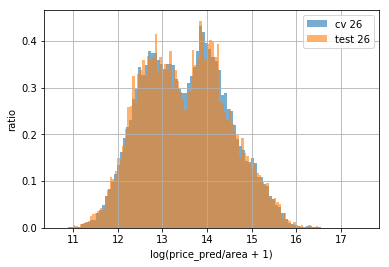

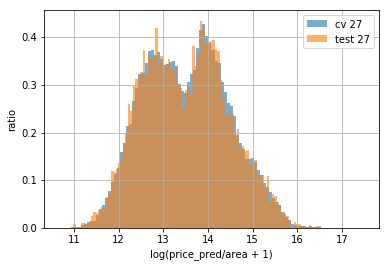

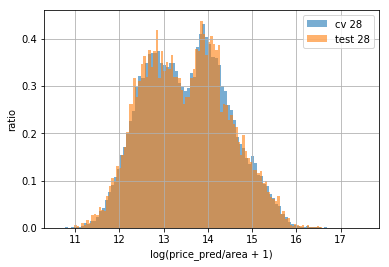

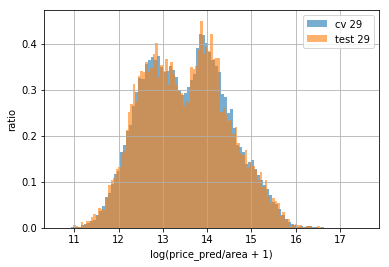

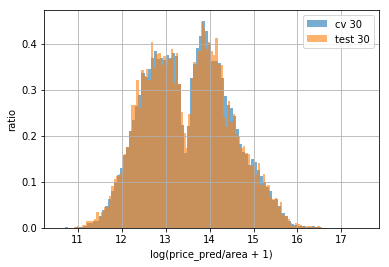

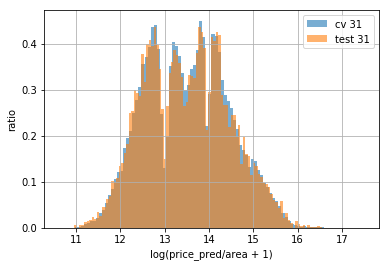

In [59]:
for i in idx_models:
    #plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
    plt.hist(cv['log_parea_pred_%d'%i], bins=100, label='cv %d'%i, normed=True, alpha=0.6)
    plt.hist(test['log_parea_pred_%d'%i], bins=100, label='test %d'%i, normed=True, alpha=0.6)
    plt.xlabel('log(price_pred/area + 1)'); plt.ylabel('ratio')
    plt.legend(); plt.grid(); plt.show()

### Log price distribution

In [62]:
list(cv.columns)

['building_id',
 'building_area',
 'total_price',
 'pred_1',
 'log_pred_1',
 'log_parea_pred_1',
 'pred_2',
 'log_pred_2',
 'log_parea_pred_2',
 'pred_3',
 'log_pred_3',
 'log_parea_pred_3',
 'pred_4',
 'log_pred_4',
 'log_parea_pred_4',
 'pred_5',
 'log_pred_5',
 'log_parea_pred_5',
 'pred_6',
 'log_pred_6',
 'log_parea_pred_6',
 'pred_7',
 'log_pred_7',
 'log_parea_pred_7',
 'pred_8',
 'log_pred_8',
 'log_parea_pred_8',
 'pred_9',
 'log_pred_9',
 'log_parea_pred_9',
 'pred_10',
 'log_pred_10',
 'log_parea_pred_10',
 'pred_11',
 'log_pred_11',
 'log_parea_pred_11',
 'pred_12',
 'log_pred_12',
 'log_parea_pred_12',
 'pred_13',
 'log_pred_13',
 'log_parea_pred_13',
 'pred_14',
 'log_pred_14',
 'log_parea_pred_14',
 'pred_15',
 'log_pred_15',
 'log_parea_pred_15',
 'pred_16',
 'log_pred_16',
 'log_parea_pred_16',
 'pred_17',
 'log_pred_17',
 'log_parea_pred_17',
 'pred_18',
 'log_pred_18',
 'log_parea_pred_18',
 'pred_19',
 'log_pred_19',
 'log_parea_pred_19',
 'pred_20',
 'log_pred_20',

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


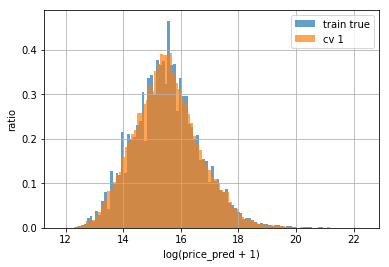

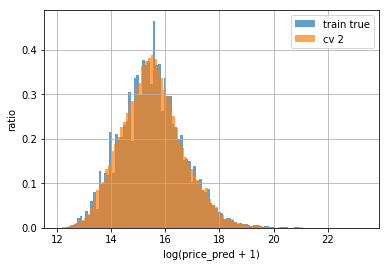

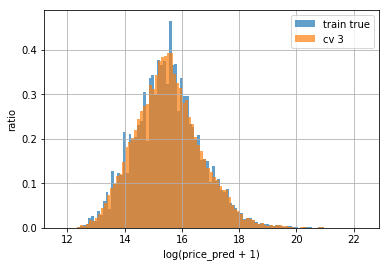

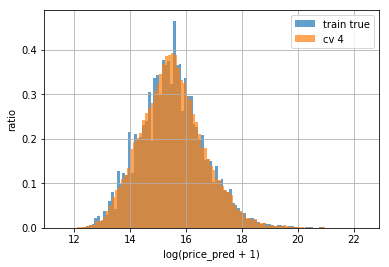

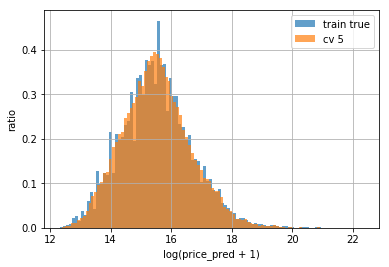

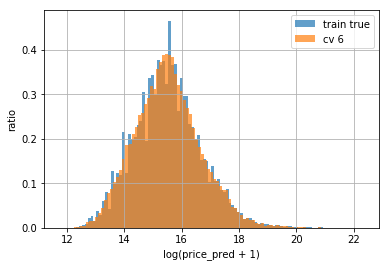

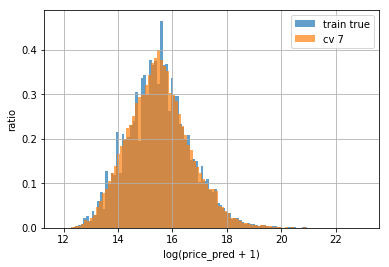

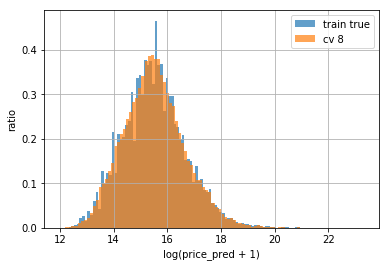

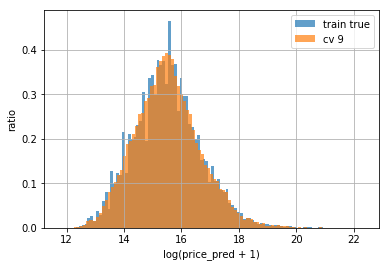

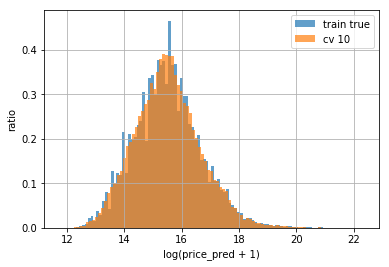

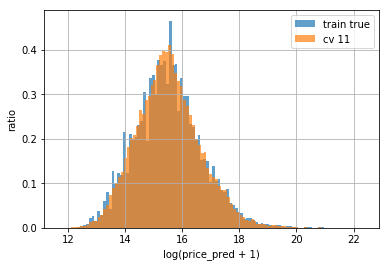

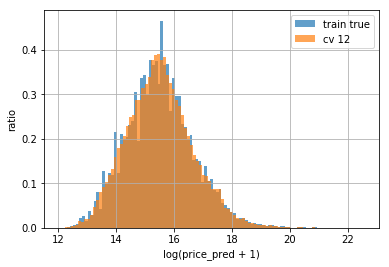

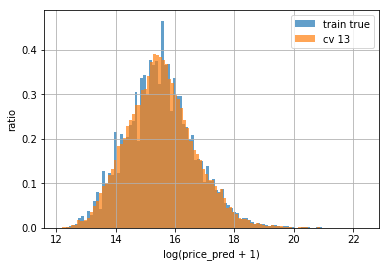

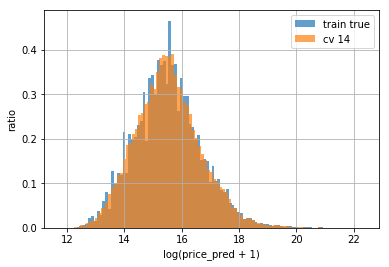

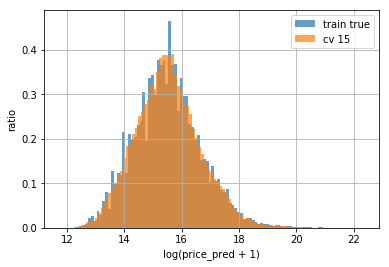

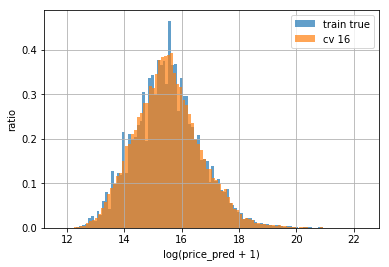

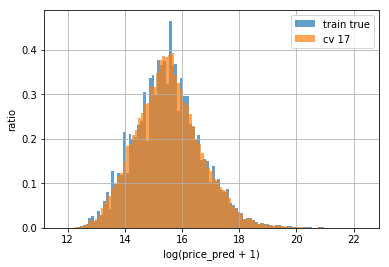

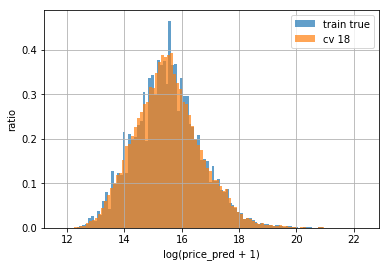

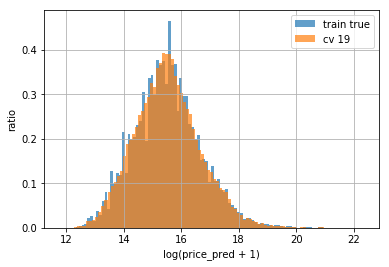

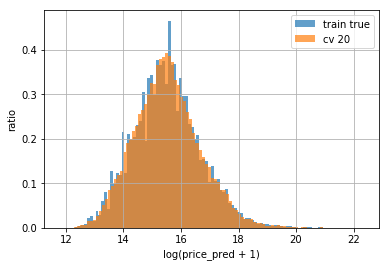

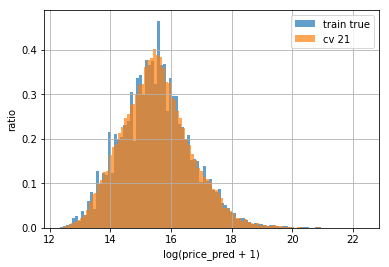

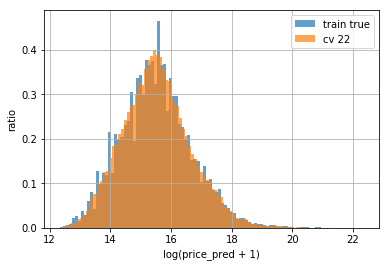

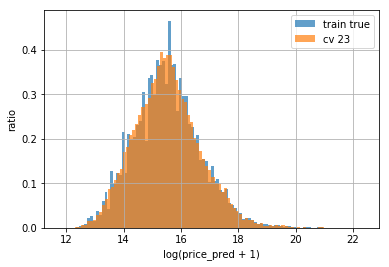

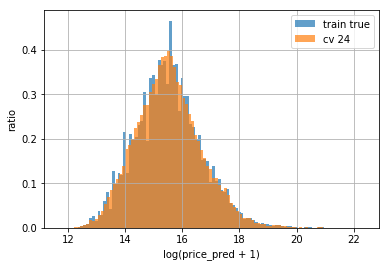

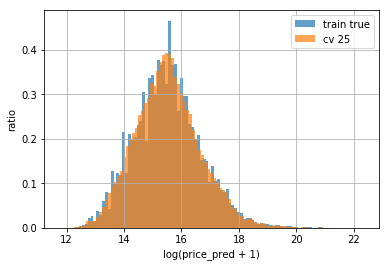

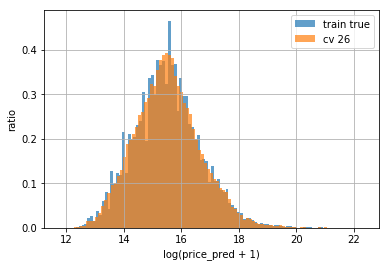

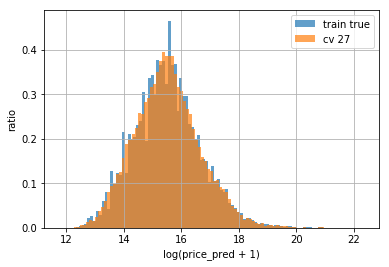

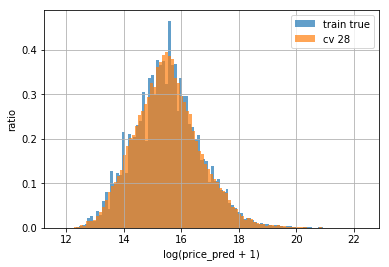

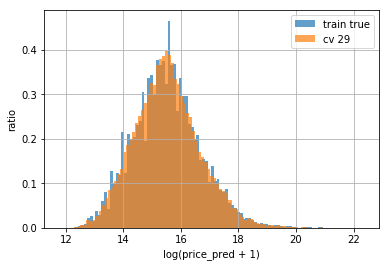

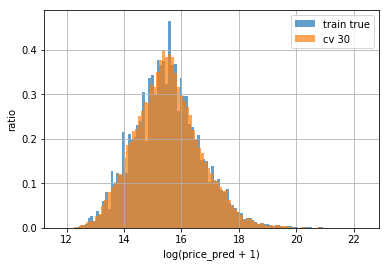

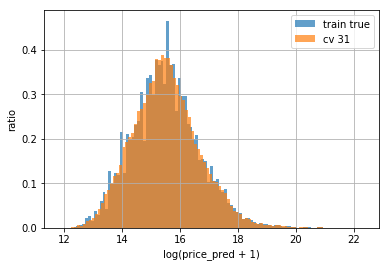

In [63]:
for i in idx_models:
    plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True, alpha=0.7)
    plt.hist(cv['log_pred_%d'%i], bins=100, label='cv %d'%i, normed=True, alpha=0.7)
    #plt.hist(test['log_pred_%d'%i], bins=100, label='test %d'%i, normed=True, alpha=0.6)
    plt.xlabel('log(price_pred + 1)'); plt.ylabel('ratio')
    plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


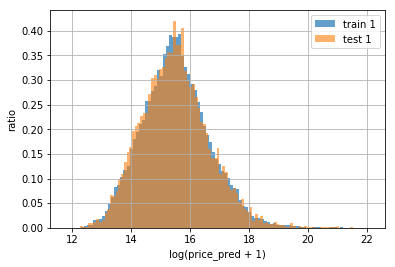

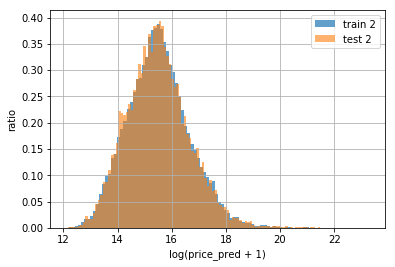

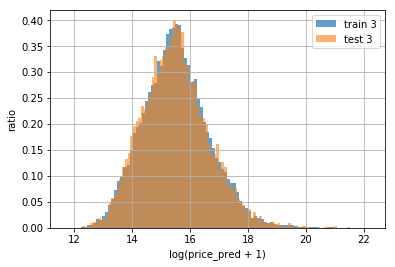

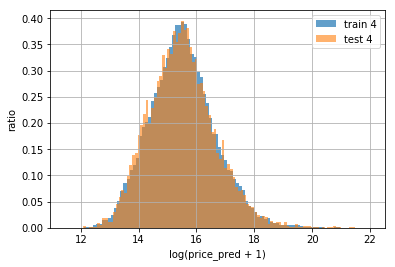

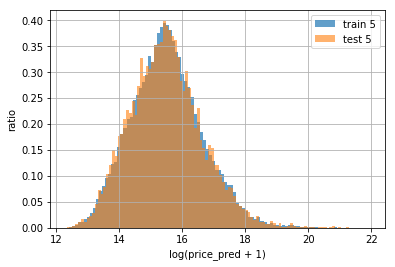

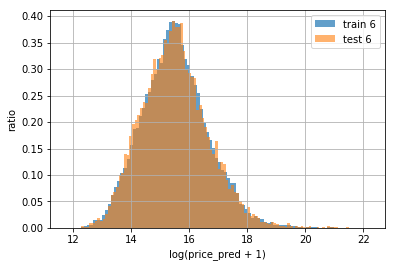

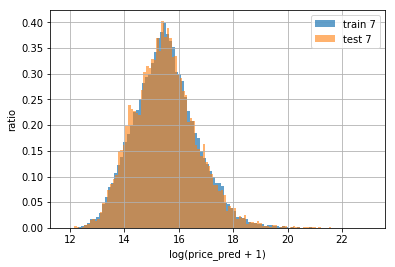

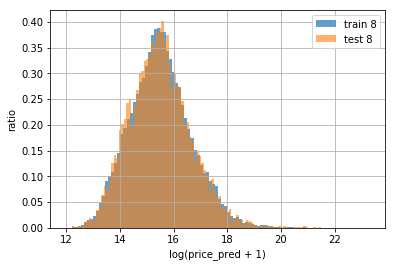

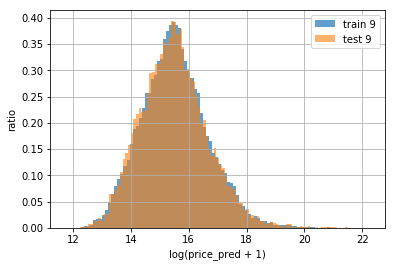

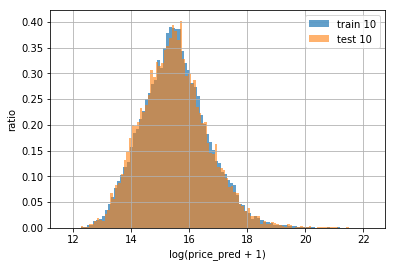

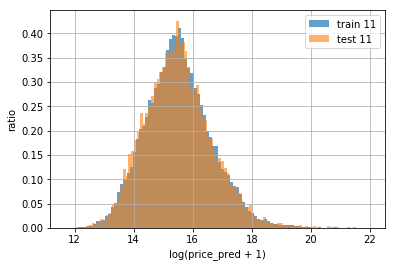

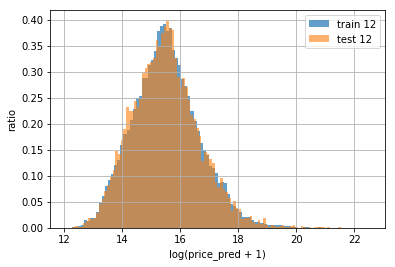

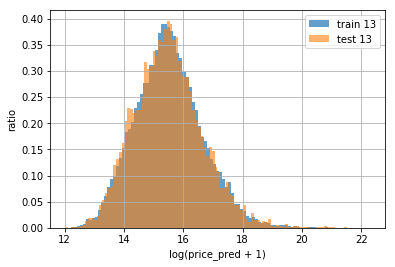

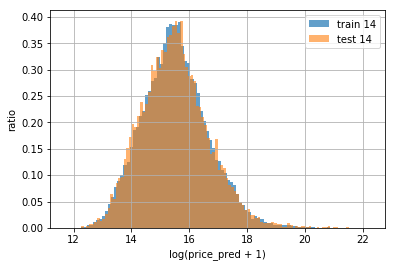

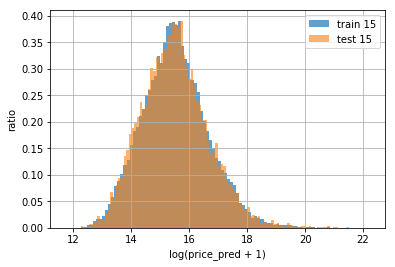

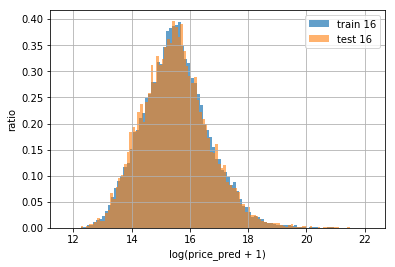

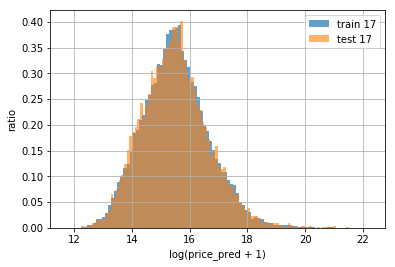

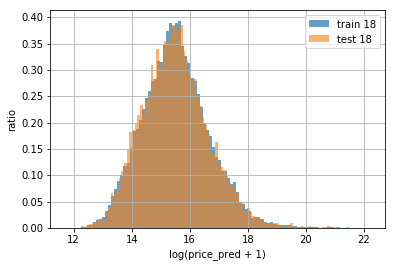

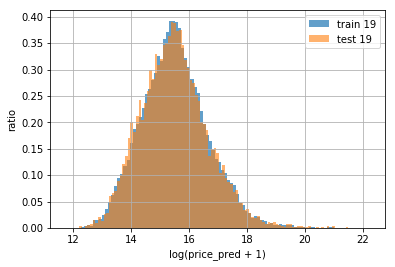

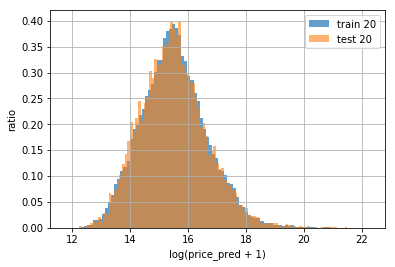

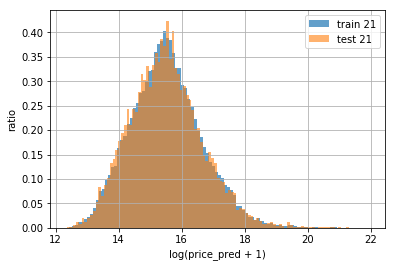

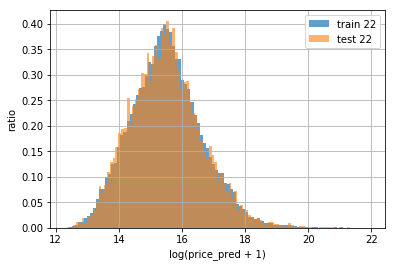

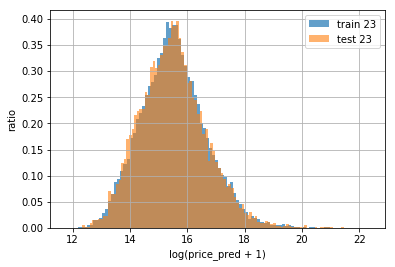

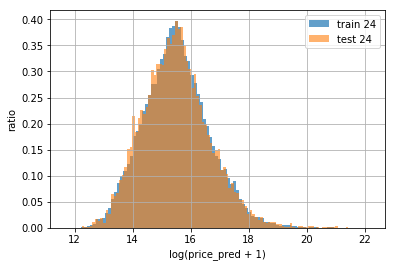

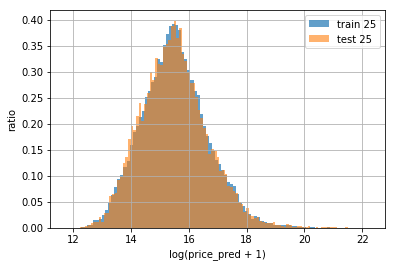

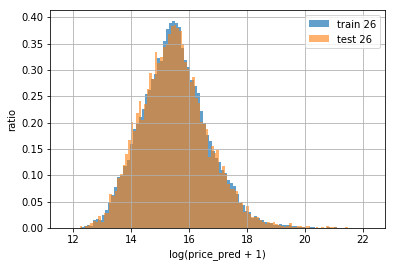

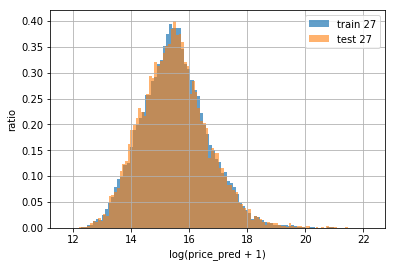

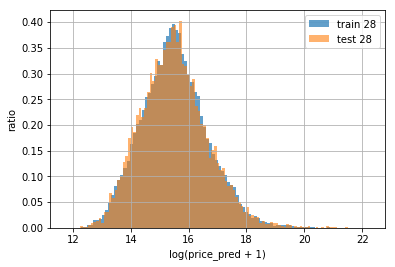

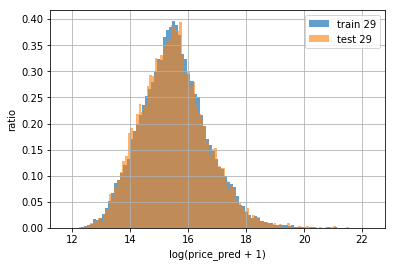

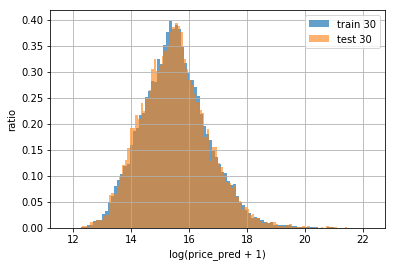

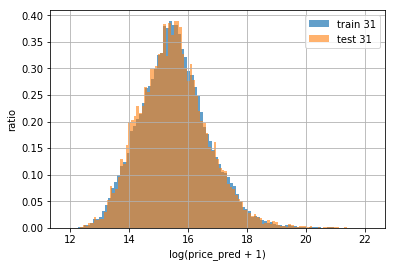

In [60]:
for i in idx_models:
    plt.hist(cv['log_pred_%d'%i], bins=100, label='train %d'%i, normed=True, alpha=0.7)
    plt.hist(test['log_pred_%d'%i], bins=100, label='test %d'%i, normed=True, alpha=0.6)
    plt.xlabel('log(price_pred + 1)'); plt.ylabel('ratio')
    plt.legend(); plt.grid(); plt.show()

### Compute submission

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


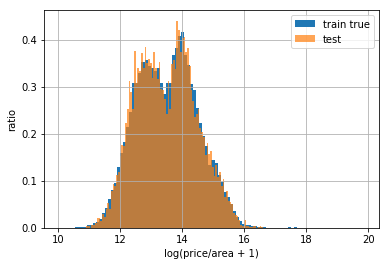

In [23]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

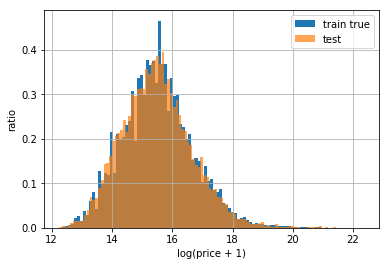

In [24]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

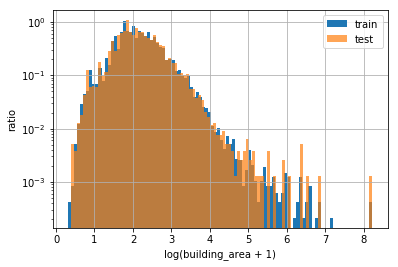

In [25]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()